In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Compute the time elapsed
"""
def tic():
    global tic_time
    tic_time = time.time()
    
def toc():
    return time.time() - tic_time

In [3]:
"""
Load MNIST data
Return: all 70000(train + val + test) images and 70000(train + val + test) labels
"""
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    labels = np.append(np.append(mnist.train.labels, mnist.validation.labels, axis=0), mnist.test.labels, axis=0)
    return images, labels #images shape = (70000, 784), labels shape = (70000, 10)

In [4]:
"""
Define the Generator
"""
def generator(noises_input, labels_input, n_1, n_2, n_3, n_out):
    with tf.variable_scope('generator'):
        inputs = tf.concat([noises_input, labels_input], 1, name='inputs')
        Z1 = tf.contrib.layers.fully_connected(inputs, n_1, activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        Z2 = tf.contrib.layers.fully_connected(A1, n_2, activation_fn=None, scope='Z2')
        A2 = tf.nn.leaky_relu(Z2, name='A2')
        Z3 = tf.contrib.layers.fully_connected(A2, n_3, activation_fn=None, scope='Z3')
        A3 = tf.nn.leaky_relu(Z3, name='A3')
        Z_out = tf.contrib.layers.fully_connected(A3, n_out, activation_fn=None, scope='Z_out')
        A_out = tf.nn.tanh(Z_out, name='A_out')
    return A_out

In [5]:
"""
Define the Discriminator
"""
def discriminator(images_input, labels_input, n_1, n_2, n_3, n_out, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        inputs = tf.concat([images_input, labels_input], 1, name='inputs')
        Z1 = tf.contrib.layers.fully_connected(inputs, n_1, activation_fn=None, scope='Z1')
        A1 = tf.nn.leaky_relu(Z1, name='A1')
        A1_dropout = tf.nn.dropout(A1, 0.7, name='A1_dropout')
        Z2 = tf.contrib.layers.fully_connected(A1_dropout, n_2, activation_fn=None, scope='Z2')
        A2 = tf.nn.leaky_relu(Z2, name='A2')
        A2_dropout = tf.nn.dropout(A2, 0.7, name='A2_dropout')
        Z3 = tf.contrib.layers.fully_connected(A2_dropout, n_3, activation_fn=None, scope='Z3')
        A3 = tf.nn.leaky_relu(Z3, name='A3')
        A3_dropout = tf.nn.dropout(A3, 0.7, name='A3_dropout')
        Z_out = tf.contrib.layers.fully_connected(A3_dropout, n_out, activation_fn=None, scope='Z_out')
    return Z_out

In [6]:
"""
Define and Train Generative Adversarial Networks(GANs) Model
Return: history of costs(both generator and discriminator) 
        samples generated in each epoch
"""
def MNIST_Conditional_GAN(hyperparams):
    tf.reset_default_graph()
    
    #Load data#
    mnist_images, mnist_labels = load_data() #images shape = (70000, 784), labels shape = (70000, 10)
    mnist_images = mnist_images * 2 - 1
    
    #Hyperparameters settings and properties#
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    label_smooth = hyperparams['label_smooth']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    generator_n_2 = hyperparams['generator_n_2']
    generator_n_3 = hyperparams['generator_n_3']
    generator_n_out = hyperparams['generator_n_out']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    discriminator_n_2 = hyperparams['discriminator_n_2']
    discriminator_n_3 = hyperparams['discriminator_n_3']
    discriminator_n_out = hyperparams['discriminator_n_out']
    gen_learning_rate = hyperparams['gen_learning_rate']
    dis_learning_rate = hyperparams['dis_learning_rate']
    adam_beta1 = hyperparams['adam_beta1']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_size = mnist_images.shape[1]
    label_size = mnist_labels.shape[1]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    
    #Define placeholders#
    real_images = tf.placeholder(tf.float32, (None, image_size), name='real_images')
    noises_input = tf.placeholder(tf.float32, (None, noise_size), name='noises_input')
    labels_input = tf.placeholder(tf.float32, (None, label_size), name='labels_input')
    
    #Define the outputs of generator and discriminator#
    fake_images = generator(noises_input, labels_input, generator_n_1, generator_n_2, generator_n_3, generator_n_out)
    real_logits = discriminator(real_images, labels_input, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_out)
    fake_logits = discriminator(fake_images, labels_input, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_out, reuse=True)
    
    #Define costs of discriminator(fake and real data) and generator#
    dis_real_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.multiply(tf.ones_like(real_logits), (1. - label_smooth))))
    dis_fake_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    
    #Define the optimization#
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_optimize = tf.train.AdamOptimizer(learning_rate=gen_learning_rate, beta1=adam_beta1, name='gen_optimize').minimize(gen_cost, var_list=gen_vars)
    dis_optimize = tf.train.AdamOptimizer(learning_rate=dis_learning_rate, beta1=adam_beta1, name='dis_optimize').minimize(dis_cost, var_list=dis_vars)
    
    #Training#
    costs_history = {
        'dis_cost_real_iter': [],
        'dis_cost_fake_iter': [],
        'dis_cost_iter': [],
        'gen_cost_iter': []
    }
    sample_images_generated = np.empty((0, sample_size, image_size))
    sample_noises_input = np.random.uniform(low=-1, high=1, size=(sample_size, noise_size))
    sample_labels_input = np.eye(sample_size) #because the default sample size is 10
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            
            #Reset the accumulator#
            dis_cost_real_epoch = 0.
            dis_cost_fake_epoch = 0.
            dis_cost_epoch = 0.
            gen_cost_epoch = 0.
            for j in range(total_batches):
                
                #Retrieve the data batch need to be fed#
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_size)
                labels_batch = mnist_labels[index_front:index_end].reshape(-1, label_size)
                noises_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, noise_size))
                
                #Update discriminator and generator#
                _, dis_cost_real_iter, dis_cost_fake_iter, dis_cost_iter = sess.run([dis_optimize, dis_real_cost, dis_fake_cost, dis_cost], feed_dict={real_images:images_batch, noises_input:noises_batch, labels_input:labels_batch})
                _, gen_cost_iter = sess.run([gen_optimize, gen_cost], feed_dict={noises_input:noises_batch, labels_input:labels_batch})
                
                #Compute and save the average(likely) cost in epoch and in iteration#
                dis_cost_real_epoch += dis_cost_real_iter / data_size
                dis_cost_fake_epoch += dis_cost_fake_iter / data_size
                dis_cost_epoch += dis_cost_iter / data_size
                gen_cost_epoch += gen_cost_iter / data_size
                dis_cost_real_iter /= (index_end - index_front)
                dis_cost_fake_iter /= (index_end - index_front)
                dis_cost_iter /= (index_end - index_front)
                gen_cost_iter /= (index_end - index_front)
                costs_history['dis_cost_real_iter'].append(dis_cost_real_iter)
                costs_history['dis_cost_fake_iter'].append(dis_cost_fake_iter)
                costs_history['dis_cost_iter'].append(dis_cost_iter)
                costs_history['gen_cost_iter'].append(gen_cost_iter)
                
            #Get sample image generated every epoch#
            sample_images_generated_epoch = sess.run(fake_images, feed_dict={noises_input:sample_noises_input, labels_input:sample_labels_input}).reshape(1, -1, image_size)
            sample_images_generated = np.append(sample_images_generated, sample_images_generated_epoch, axis=0)
            
            #Print the state every epoch#
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_cost_epoch, dis_cost_real_epoch, dis_cost_fake_epoch, gen_cost_epoch))
    return costs_history, sample_images_generated

In [7]:
"""
Show graphs of costs of discriminator and generator
"""
def show_graphs(costs_history, ewma_span=10):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.title('Cost - Iteration')
    plt.plot(costs_history['dis_cost_real_iter'], 'b-', alpha=0.3, label='Discriminator Real Cost')
    plt.plot(costs_history['dis_cost_fake_iter'], 'r-', alpha=0.3, label='Discriminator Fake Cost')
    plt.plot(costs_history['dis_cost_iter'], 'g-', alpha=0.3, label='Discriminator Total Cost')
    plt.plot(costs_history['gen_cost_iter'], 'k-', alpha=0.3, label='Generator Cosd')
    ewma_dis_cost_real = pd.stats.moments.ewma(np.array(costs_history['dis_cost_real_iter']), span=ewma_span)
    plt.plot(ewma_dis_cost_real, 'b-', label='Discriminator Real Cost EWMA')
    ewma_dis_cost_fake = pd.stats.moments.ewma(np.array(costs_history['dis_cost_fake_iter']), span=ewma_span)
    plt.plot(ewma_dis_cost_fake, 'r-', label='Discriminator Fake Cost EWMA')
    ewma_dis_cost = pd.stats.moments.ewma(np.array(costs_history['dis_cost_iter']), span=ewma_span)
    plt.plot(ewma_dis_cost, 'g-', label='Discriminator Total Cost EWMA')
    ewma_gen_cost = pd.stats.moments.ewma(np.array(costs_history['gen_cost_iter']), span=ewma_span)
    plt.plot(ewma_gen_cost, 'k-', label='Generator Cost EWMA')
    plt.legend(loc='best')
    plt.show()

In [8]:
"""
Show and save samples
Variables: 
    sample_images_generated shape: (num of epochs, num of samples in each epoch, num of rows of image, num of column of image)
    save: True if want to save the figures(pngs and gifs)
    folder_name: create the folder if not exists, save figures to the specific folder
"""
def show_save_samples(sample_images_generated, save=False, folder_name='MNIST_Conditional-GAN_samples', gif_frame_duration=0.25):
    #Scale images to the range of [0, 1]#
    sample_images_generated = (sample_images_generated + 1) / 2
    
    #Create folder if not exists#
    if save and not os.path.exists('./{}'.format(folder_name)):
        os.mkdir(folder_name)
        
    #Parameters#
    epochs = sample_images_generated.shape[0]
    num_sample_each_epoch = sample_images_generated.shape[1]
    
    #Output and save figures#
    for i in range(epochs):
        plt.figure(figsize=(2 * num_sample_each_epoch, 5))
        for j in range(num_sample_each_epoch):
            plt.subplot(1, num_sample_each_epoch, j + 1)
            plt.axis('off')
            plt.imshow(sample_images_generated[i, j].reshape(28, 28), cmap='gray')    
        plt.text(-169, 40, 'Epoch {}'.format(i + 1), fontsize=25) #adjust the text location
        if save:
            plt.savefig('./{}/{}.png'.format(folder_name, i + 1))
        plt.show()
        
    #Make GIF#
    if save:
        gif_frames = []
        for i in range(epochs):
            gif_frames.append(imageio.imread('./{}/{}.png'.format(folder_name, i + 1)))
        imageio.mimsave('./{}/evolution.gif'.format(folder_name), gif_frames, duration=gif_frame_duration)

In [9]:
"""
Define the hyperparameters
"""
hyperparams={
    'noise_size': 100,
    'batch_size': 128,
    'label_smooth': 0.1,
    'epoch': 100,
    'generator_n_1': 256,
    'generator_n_2': 512,
    'generator_n_3': 1024,
    'generator_n_out': 784,
    'discriminator_n_1': 1024,
    'discriminator_n_2': 512,
    'discriminator_n_3': 256,
    'discriminator_n_out': 1,
    'gen_learning_rate': 0.0001,
    'dis_learning_rate': 0.0002,
    'adam_beta1': 0.5,
    'sample_size': 10
}
costs_history, sample_images_generated = MNIST_Conditional_GAN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/100 Time Elapsed: 6.69s
Discriminator Cost: 0.3587 (Real: 0.4404 + Fake: 0.2771) Generator Cost: 2.9515
Epoch 2/100 Time Elapsed: 6.20s
Discriminator Cost: 0.2973 (Real: 0.4660 + Fake: 0.1287) Generator Cost: 3.8165
Epoch 3/100 Time Elapsed: 6.64s
Discriminator Cost: 0.2815 (Real: 0.4587 + Fake: 0.1043) Generator Cost: 4.1836
Epoch 4/100 Time Elapsed: 6.11s
Discriminator Cost: 0.2518 (Real: 0.4299 + Fake: 0.0736) Generator Cost: 4.8417
Epoch 5/100 Time Elapsed: 6.61s
Discriminator Cost: 0.2516 (Real: 0.4287 + Fake: 0.0745) Generator Cost: 5.0897
Epoch 6/100 Time Elapsed: 6.40s
Discriminator Cost: 0.2441 (Real: 0.4187 + Fake: 0.0696) Generator Cost: 5.4074
Epoch 7/100 Time Elapsed: 6.34s
Discriminator Cost: 0.2433 (Real: 0.4183 + Fake: 0.0683) Generator Cost: 5.5162
Epoch 8/100 Time Elaps

Epoch 72/100 Time Elapsed: 6.64s
Discriminator Cost: 0.6187 (Real: 0.7291 + Fake: 0.5083) Generator Cost: 1.1274
Epoch 73/100 Time Elapsed: 6.31s
Discriminator Cost: 0.6173 (Real: 0.7281 + Fake: 0.5065) Generator Cost: 1.1314
Epoch 74/100 Time Elapsed: 6.18s
Discriminator Cost: 0.6194 (Real: 0.7293 + Fake: 0.5094) Generator Cost: 1.1277
Epoch 75/100 Time Elapsed: 6.27s
Discriminator Cost: 0.6202 (Real: 0.7293 + Fake: 0.5112) Generator Cost: 1.1226
Epoch 76/100 Time Elapsed: 6.24s
Discriminator Cost: 0.6204 (Real: 0.7308 + Fake: 0.5101) Generator Cost: 1.1181
Epoch 77/100 Time Elapsed: 6.37s
Discriminator Cost: 0.6208 (Real: 0.7296 + Fake: 0.5119) Generator Cost: 1.1164
Epoch 78/100 Time Elapsed: 6.31s
Discriminator Cost: 0.6208 (Real: 0.7299 + Fake: 0.5117) Generator Cost: 1.1134
Epoch 79/100 Time Elapsed: 6.44s
Discriminator Cost: 0.6200 (Real: 0.7290 + Fake: 0.5110) Generator Cost: 1.1177
Epoch 80/100 Time Elapsed: 6.24s
Discriminator Cost: 0.6212 (Real: 0.7303 + Fake: 0.5121) Genera

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


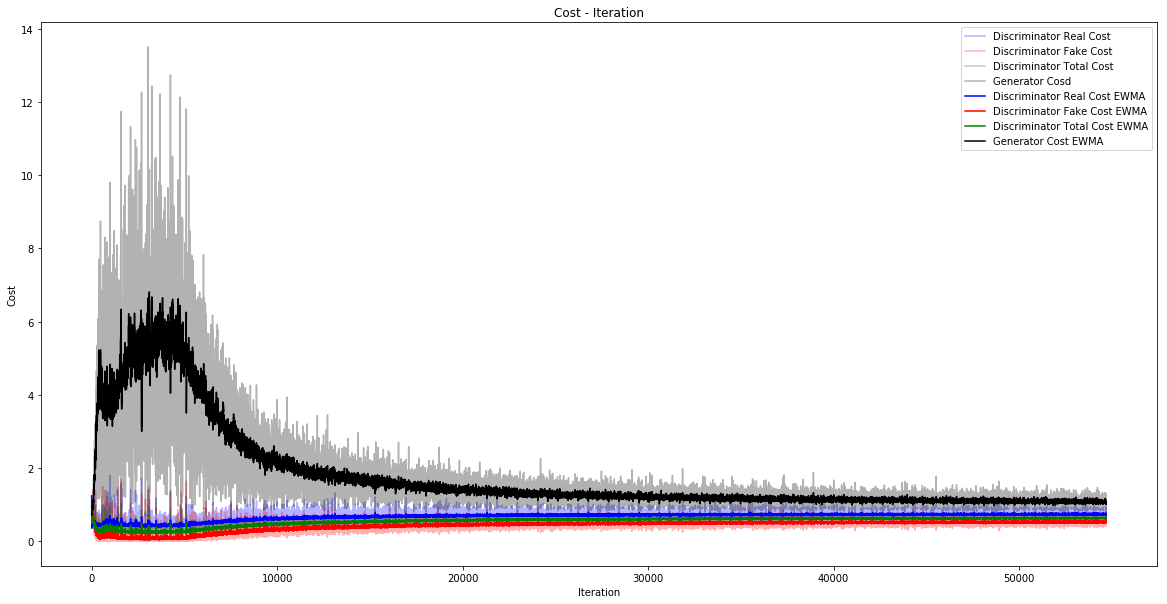

In [10]:
show_graphs(costs_history)

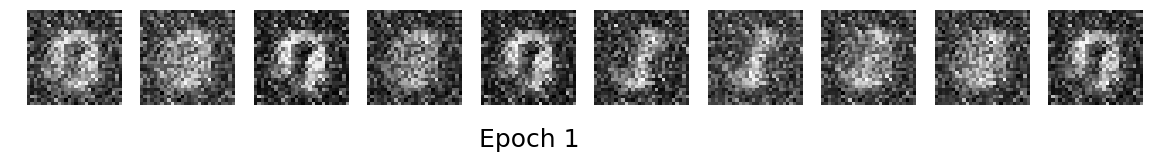

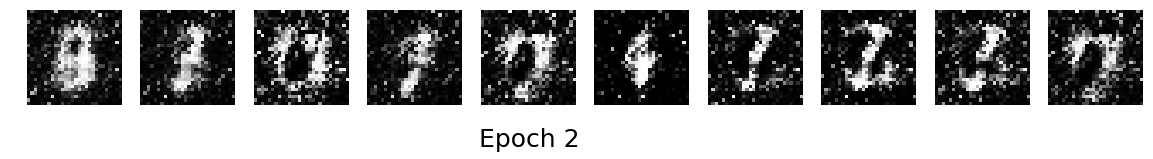

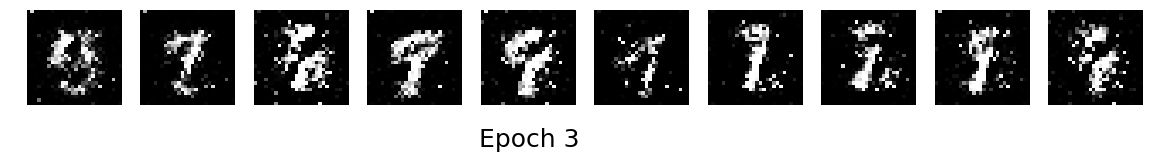

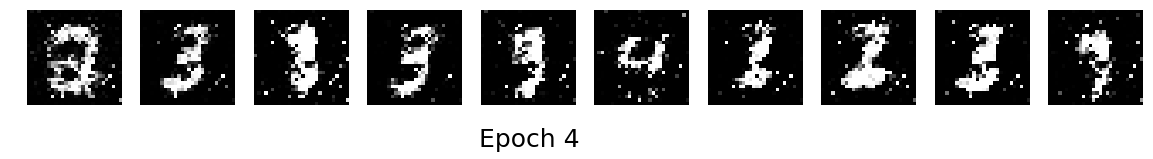

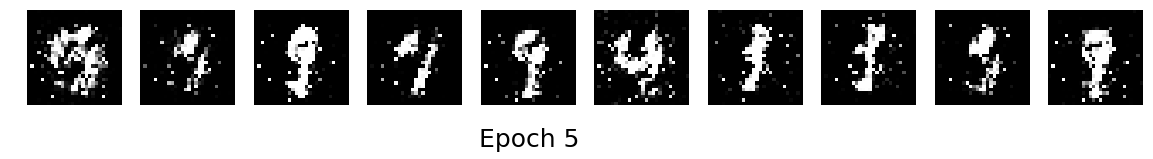

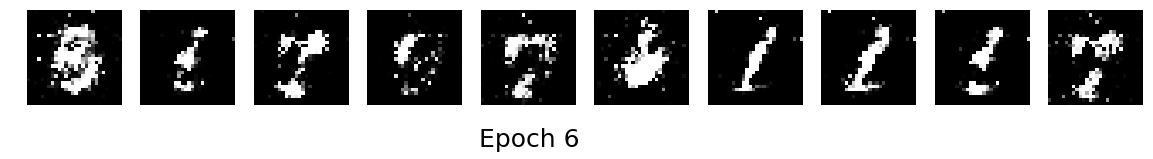

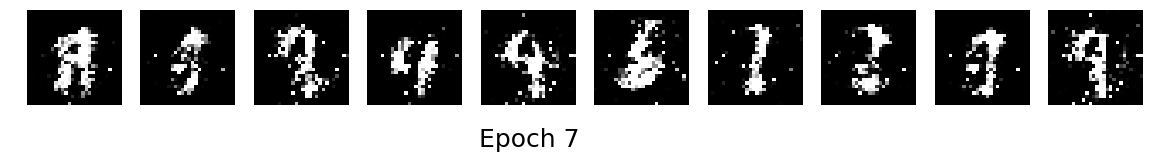

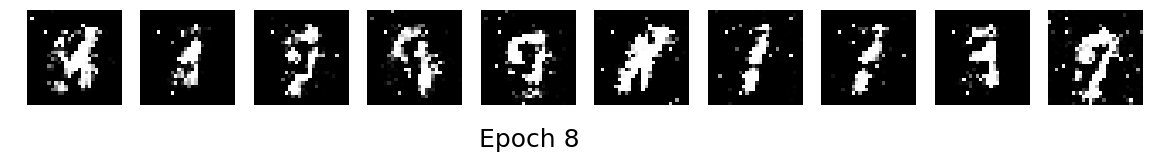

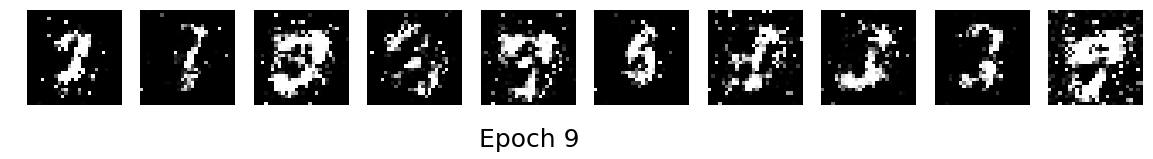

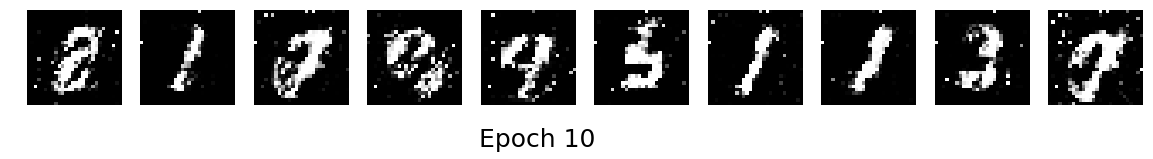

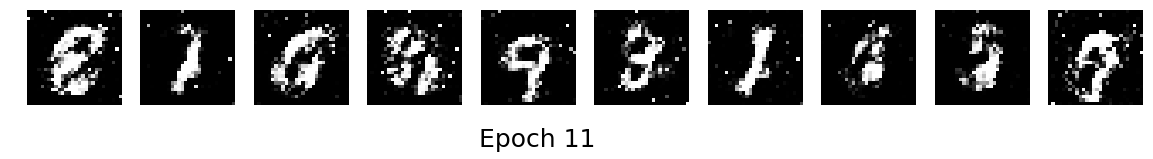

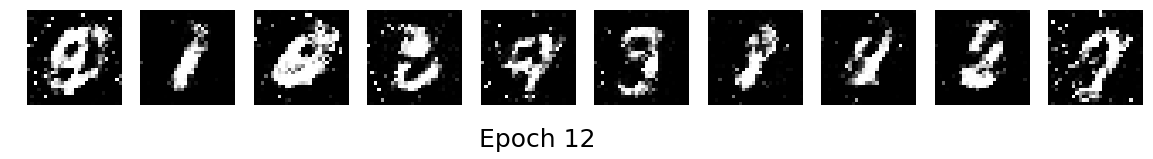

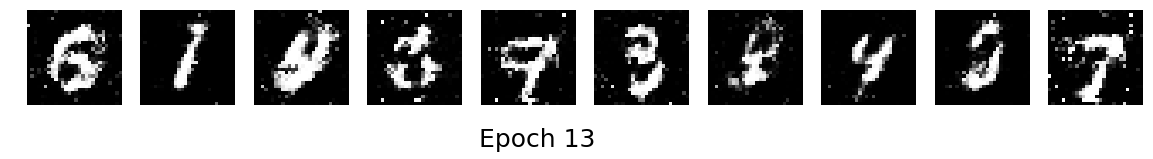

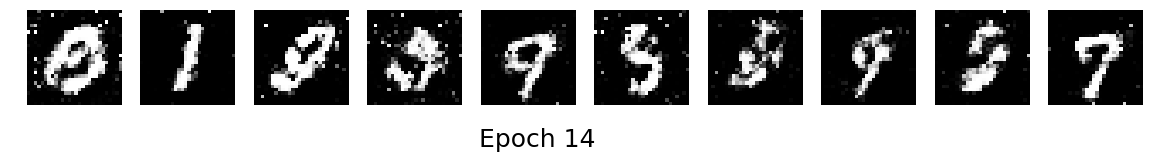

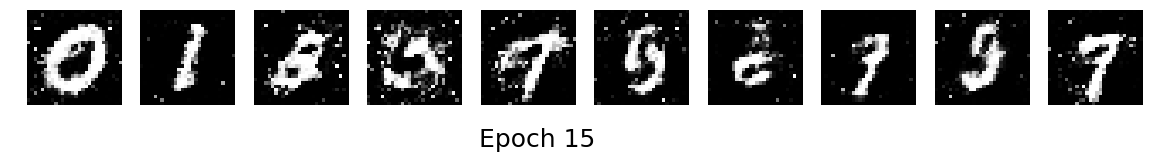

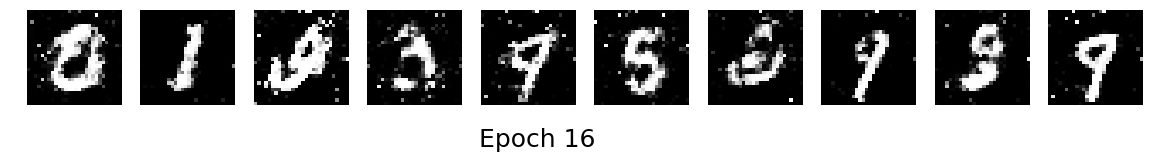

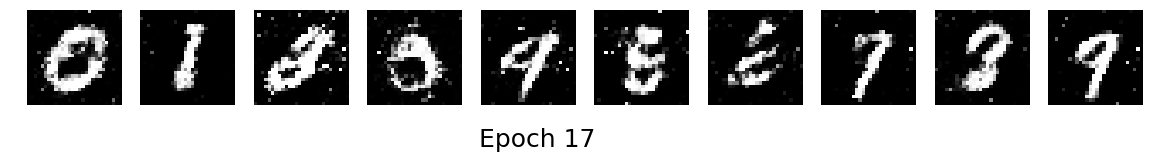

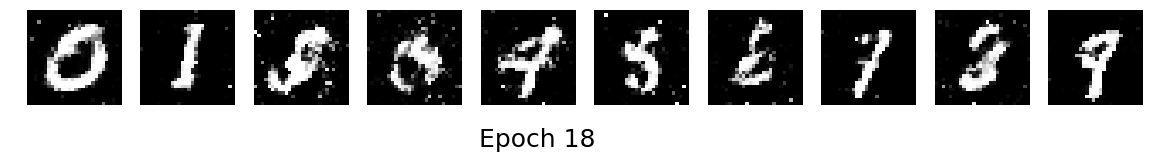

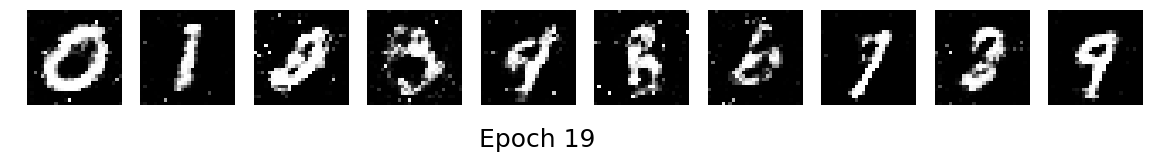

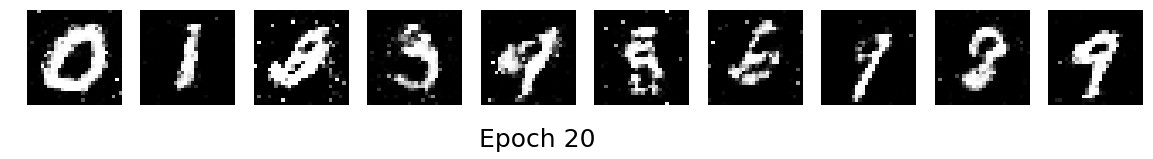

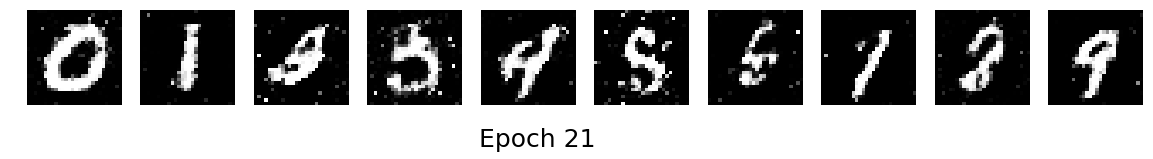

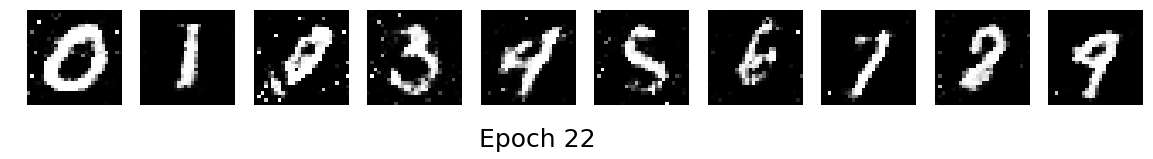

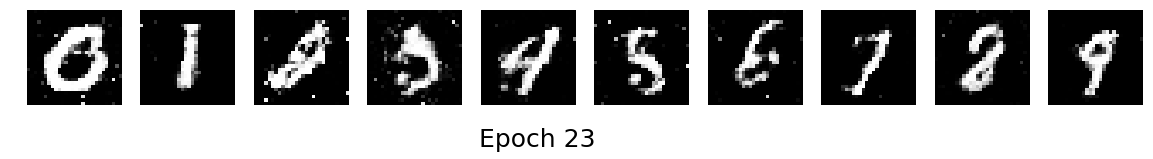

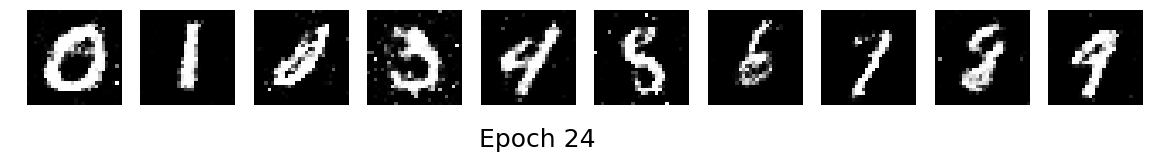

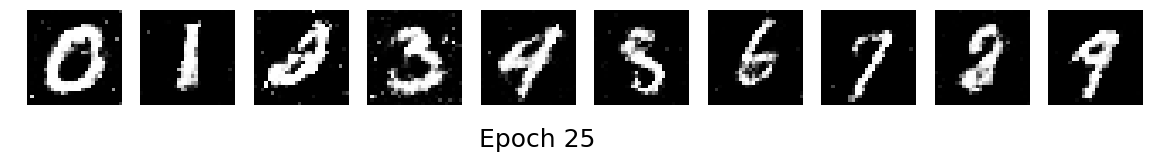

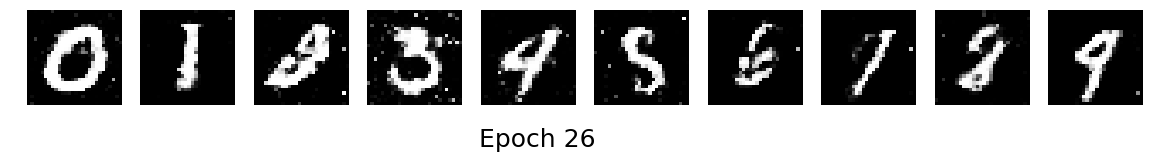

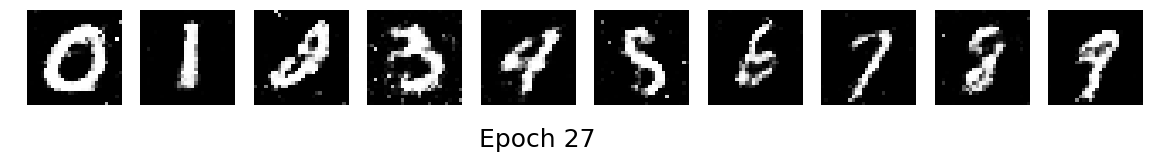

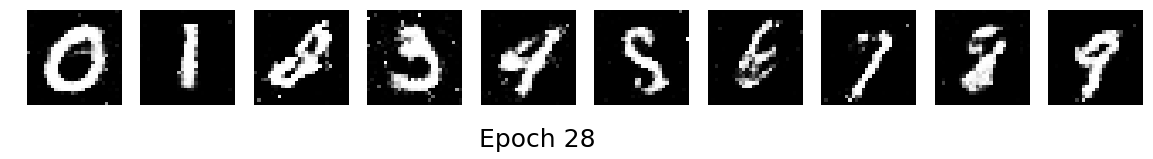

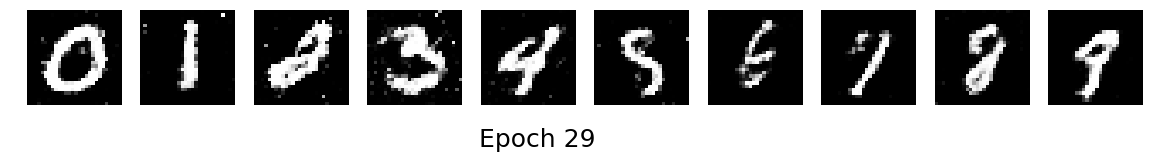

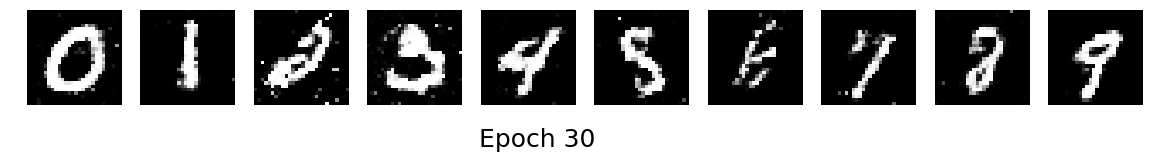

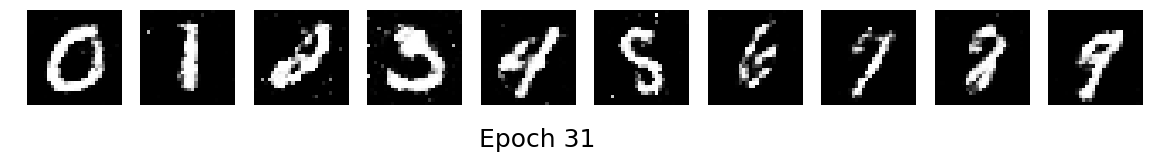

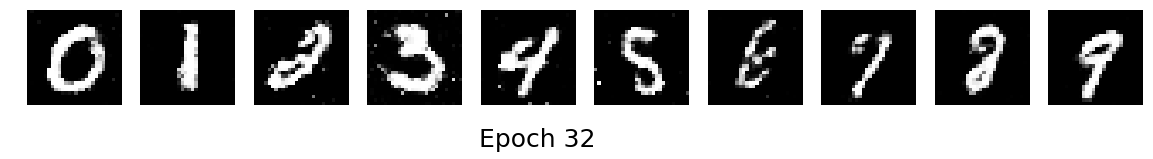

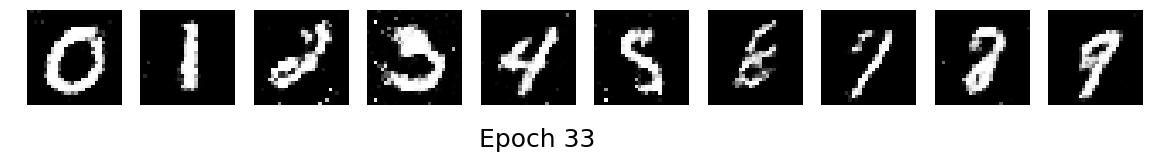

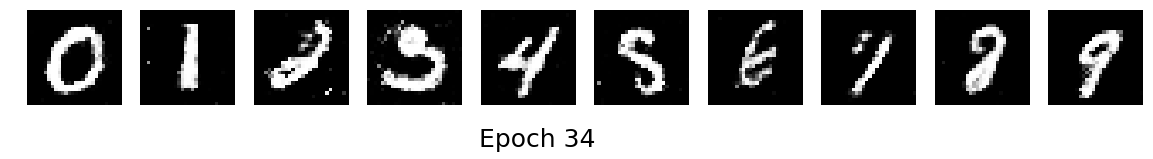

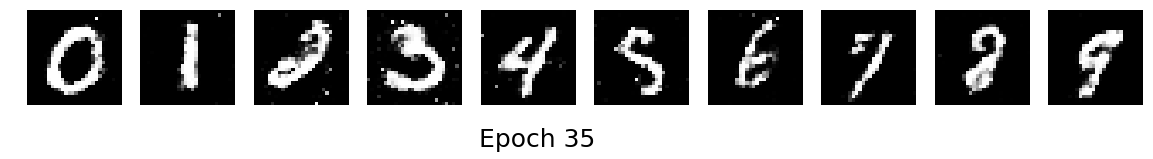

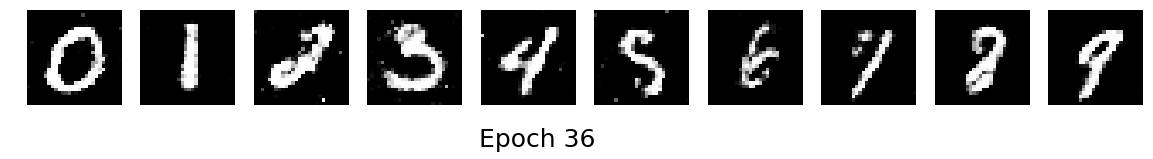

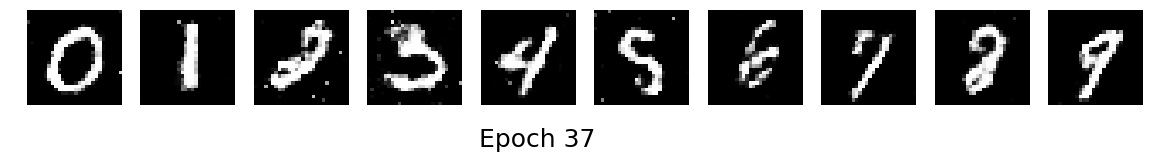

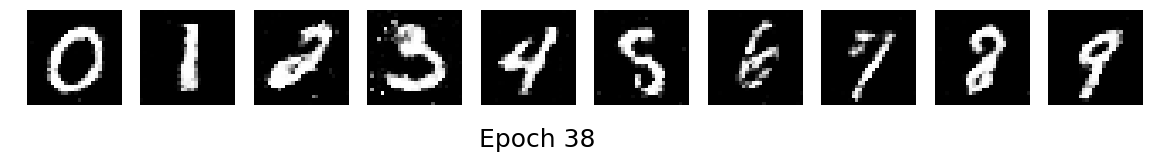

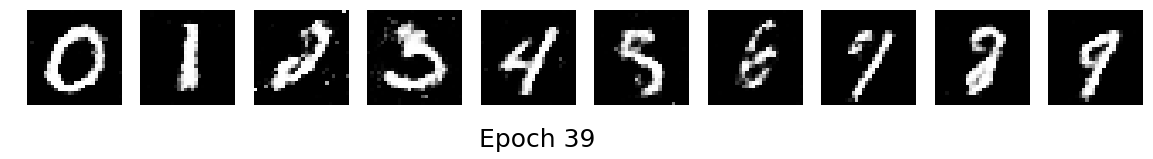

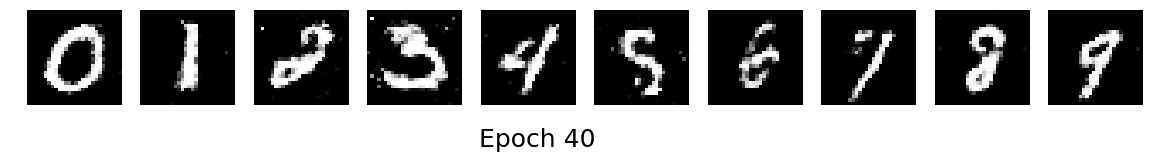

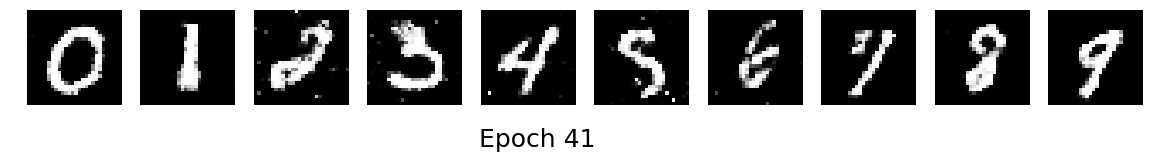

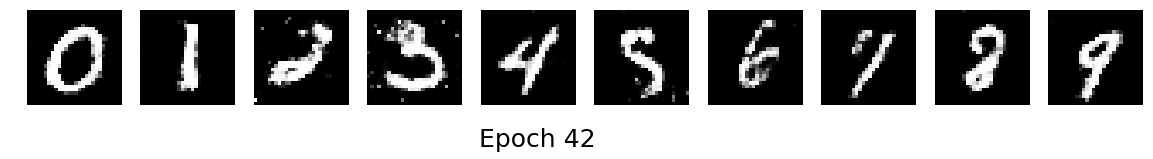

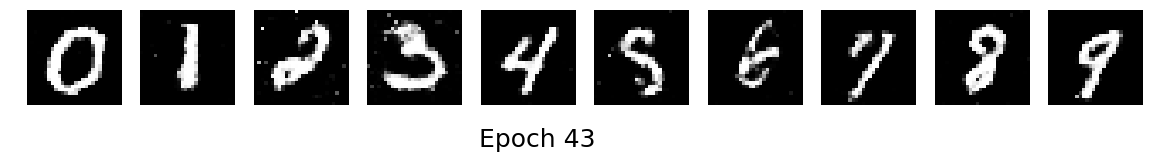

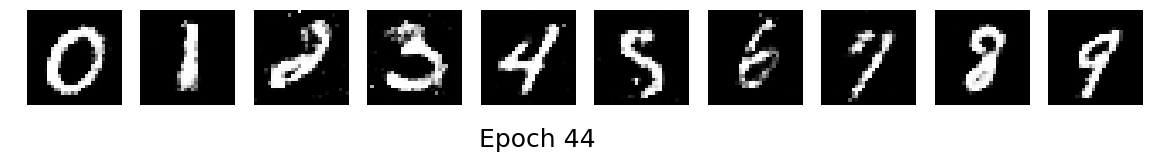

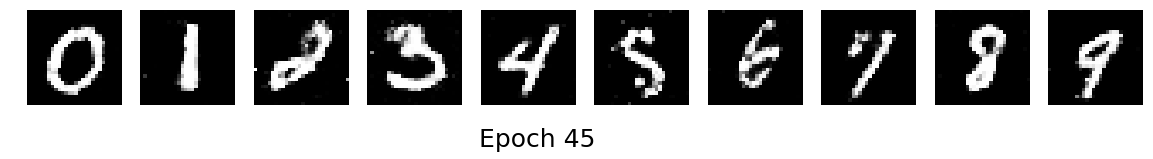

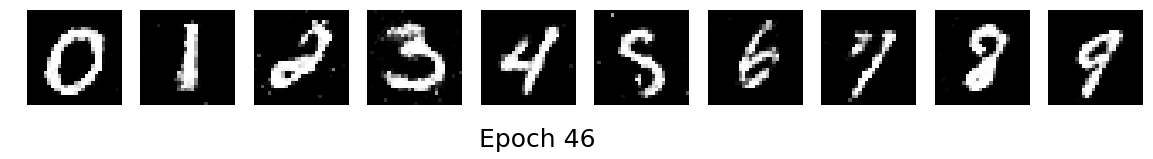

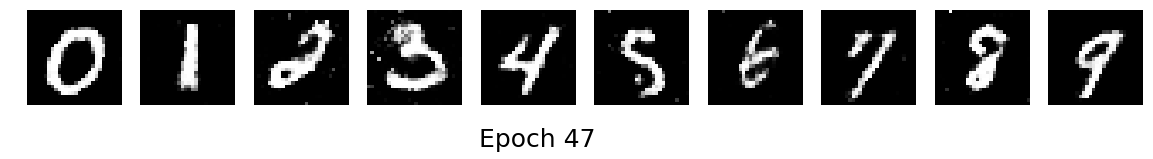

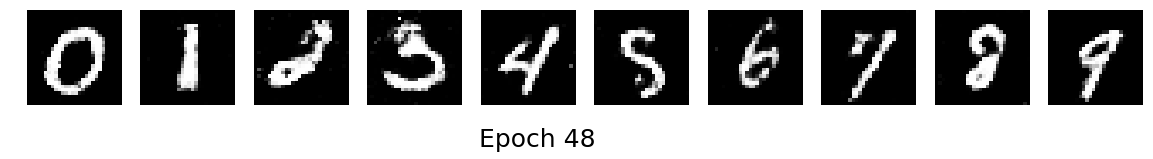

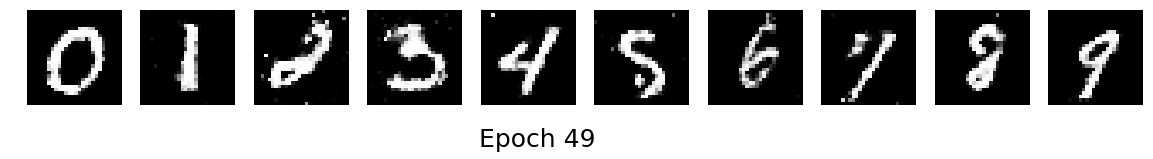

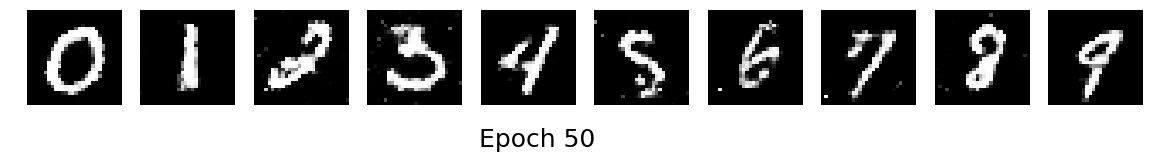

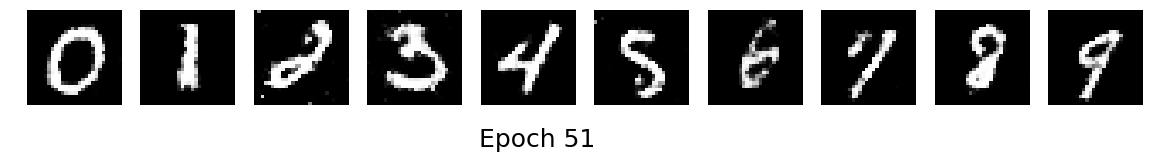

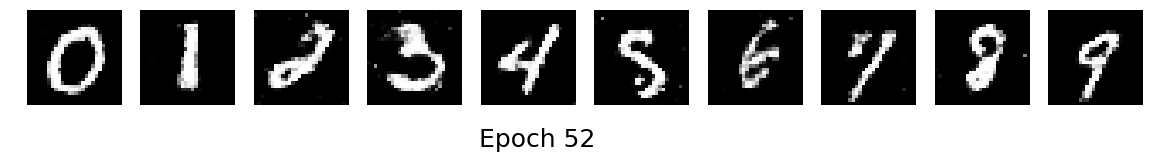

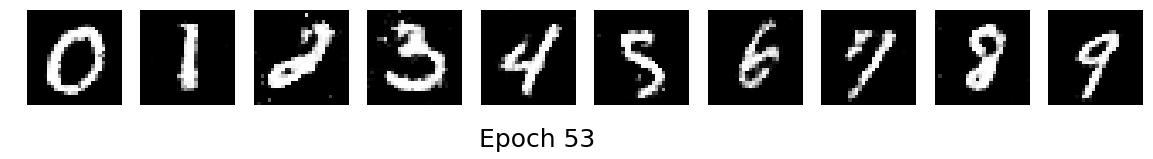

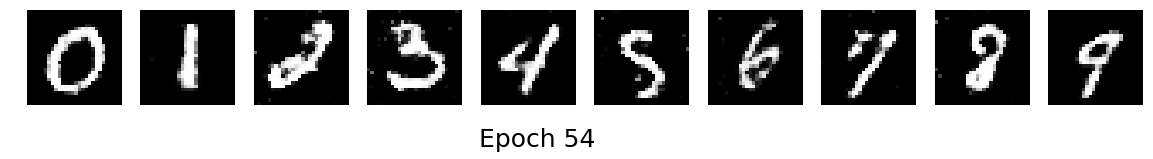

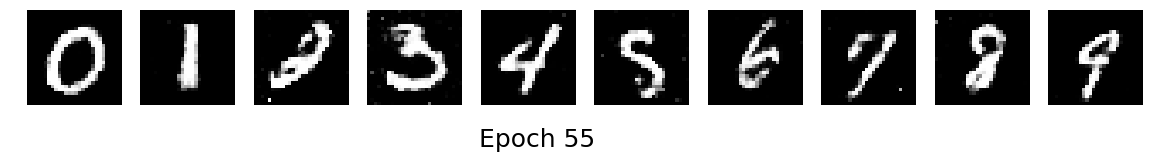

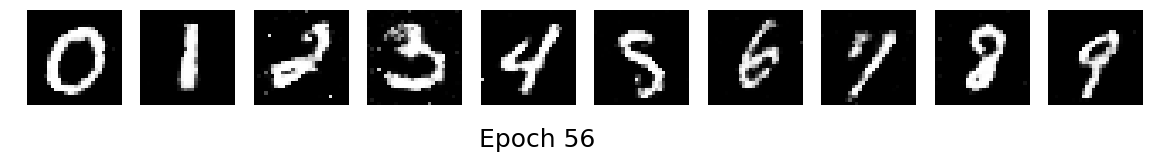

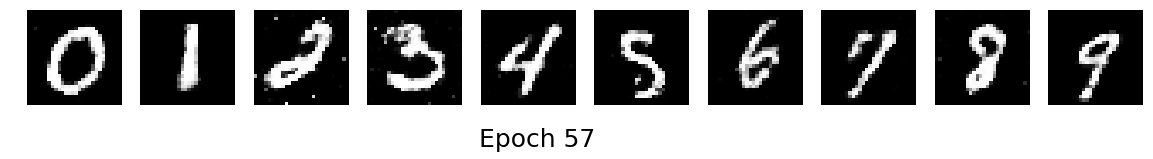

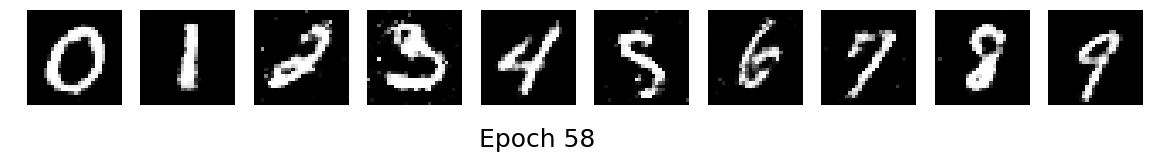

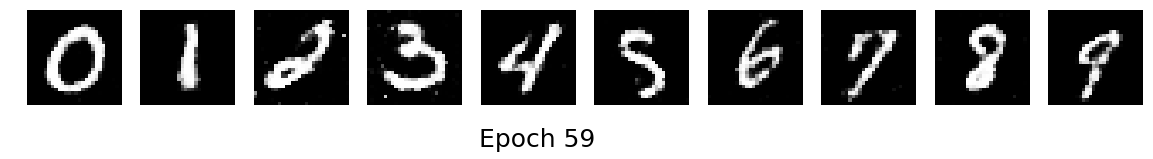

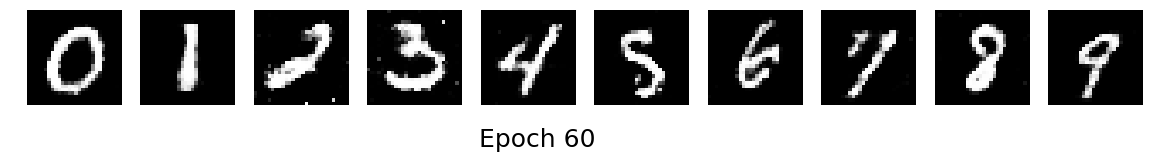

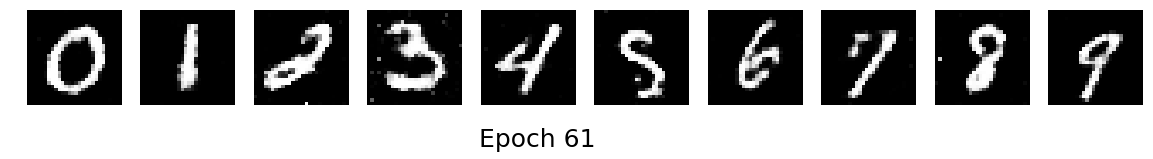

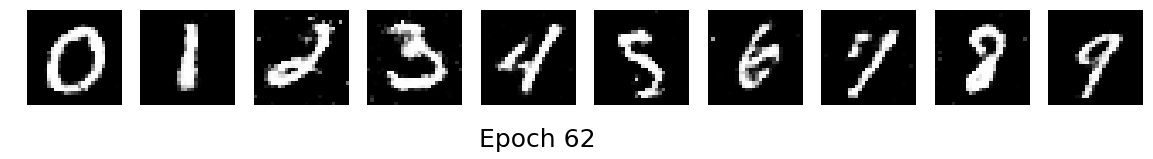

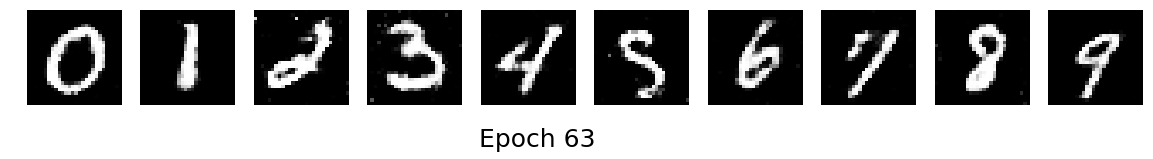

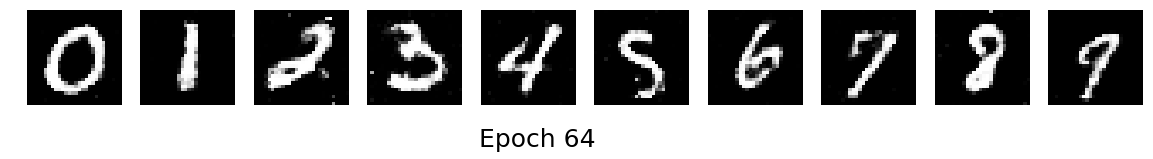

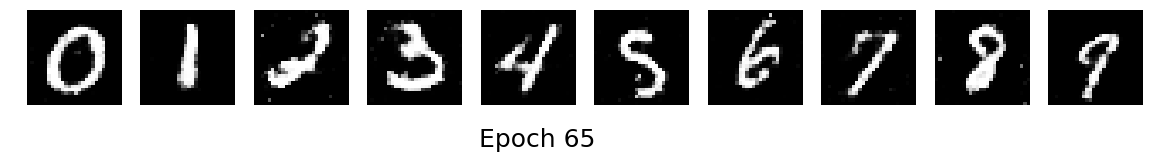

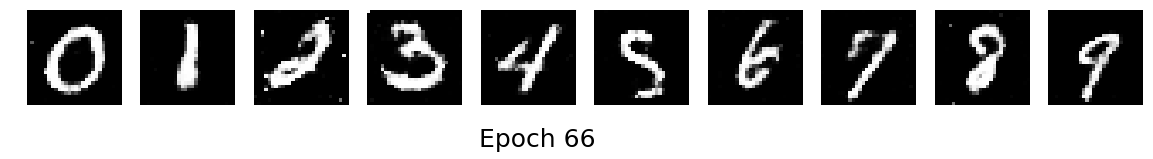

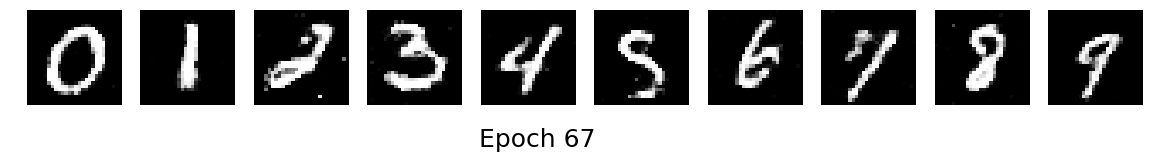

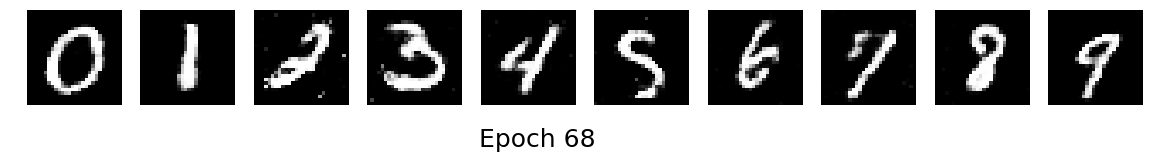

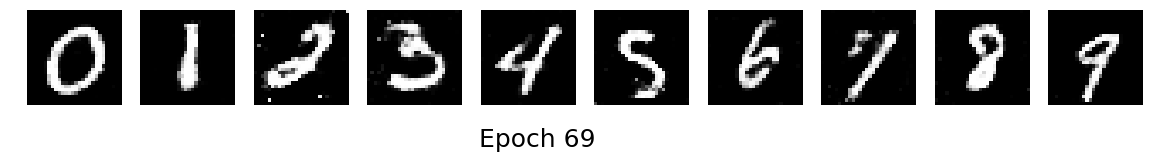

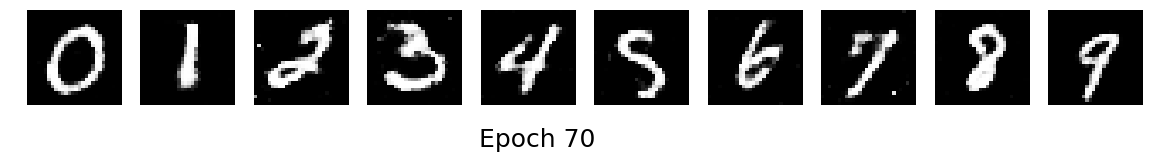

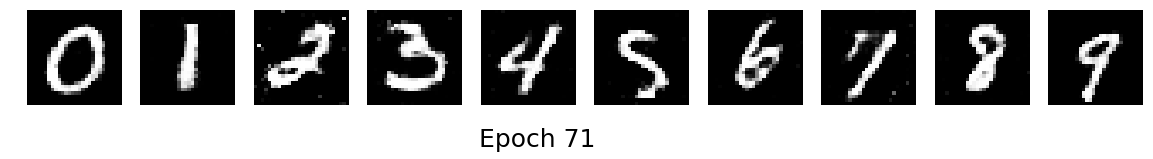

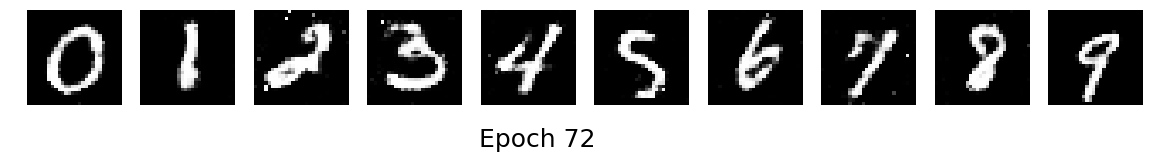

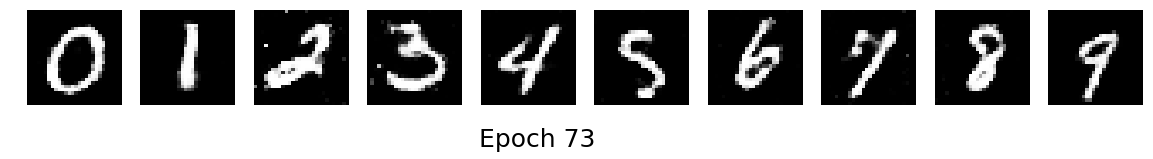

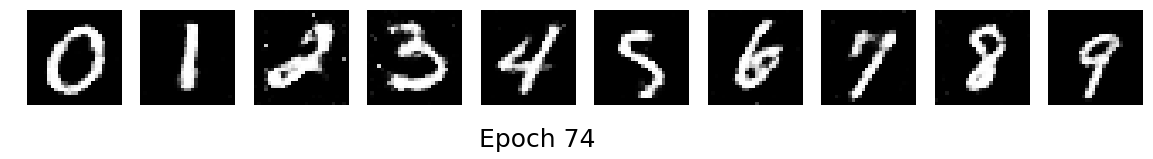

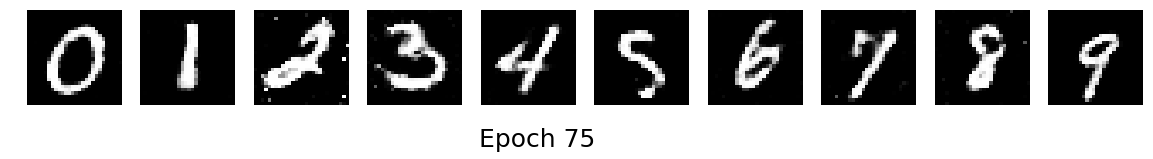

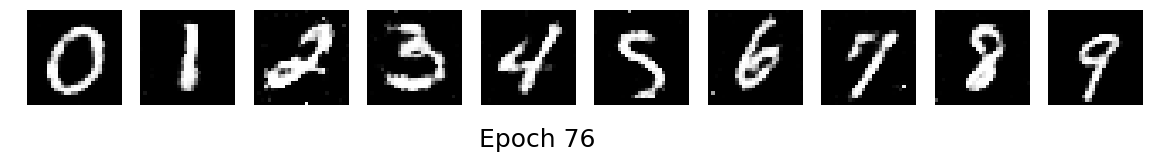

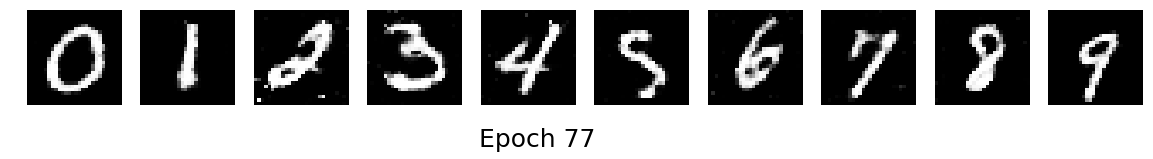

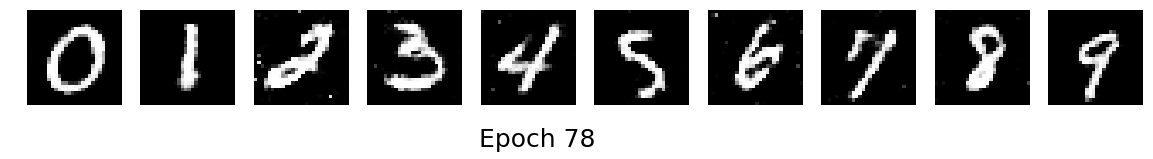

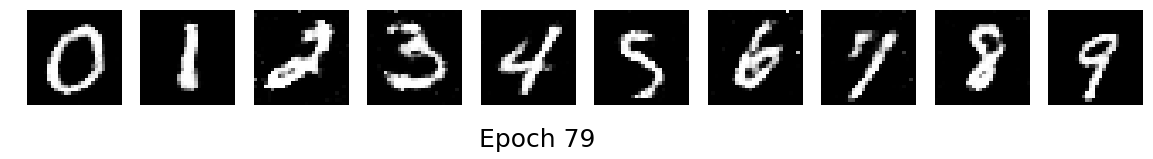

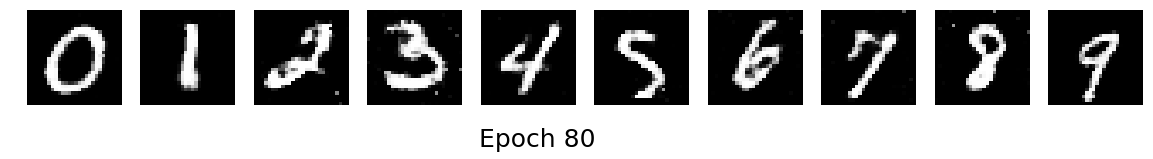

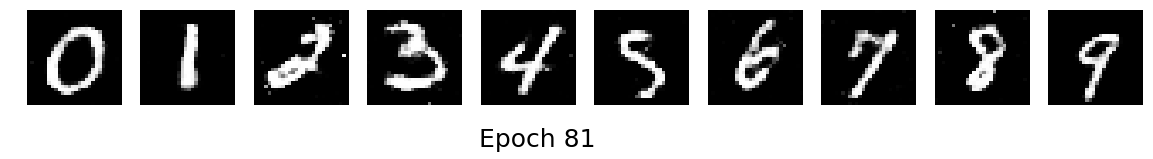

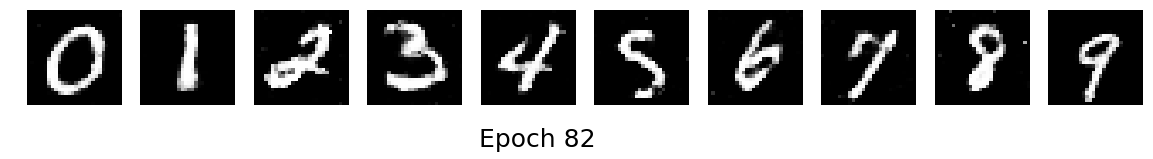

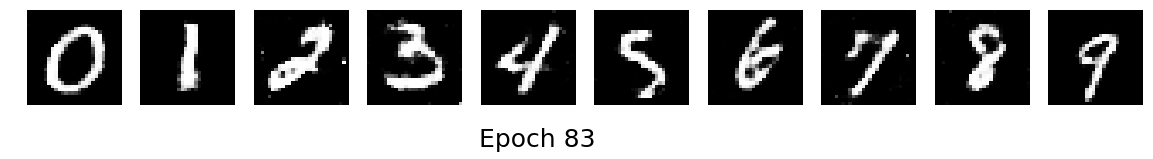

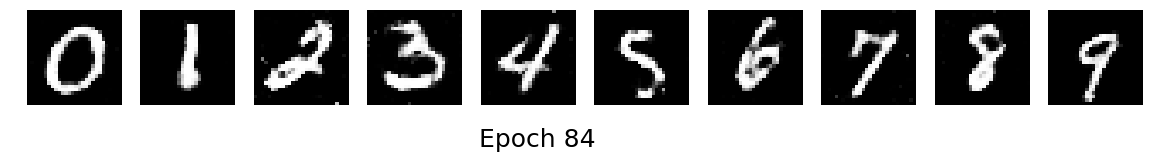

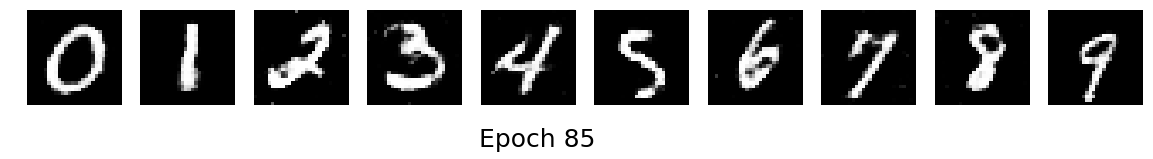

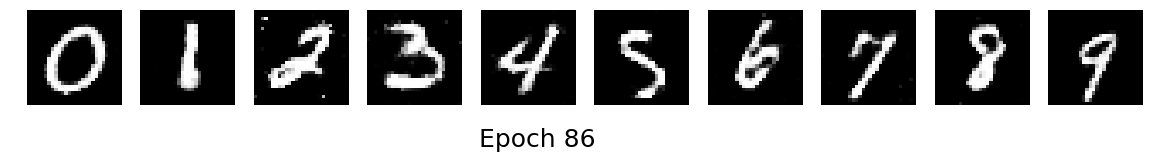

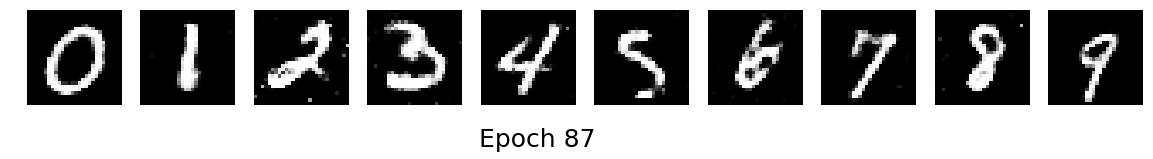

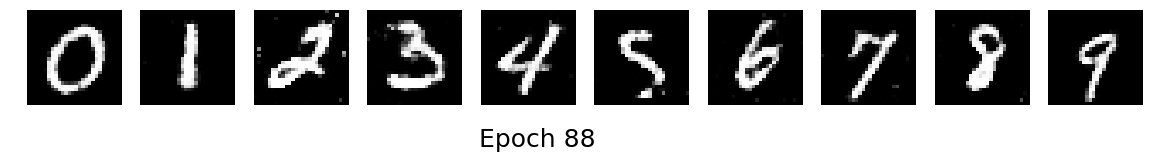

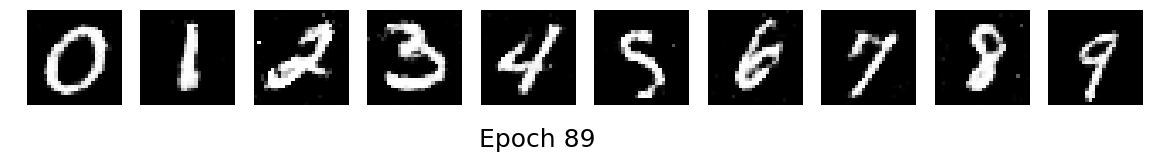

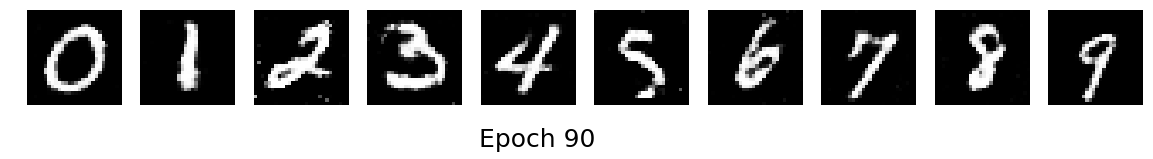

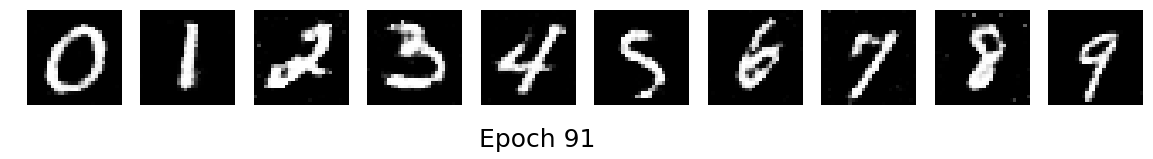

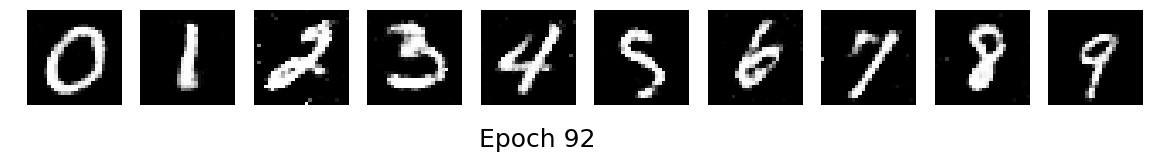

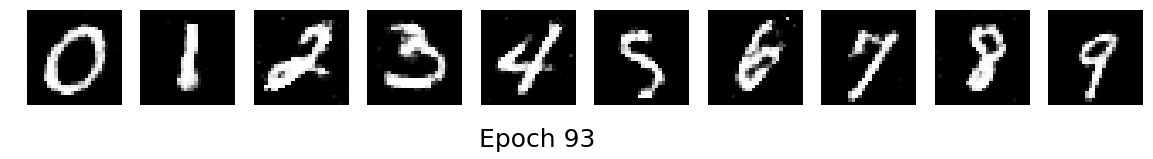

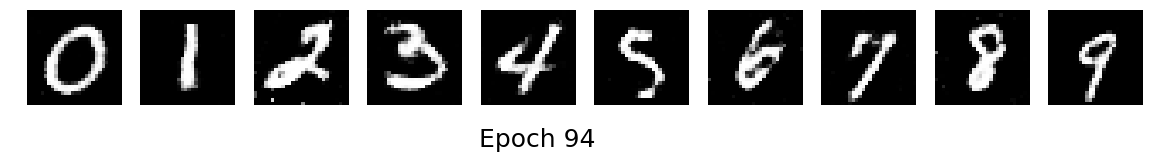

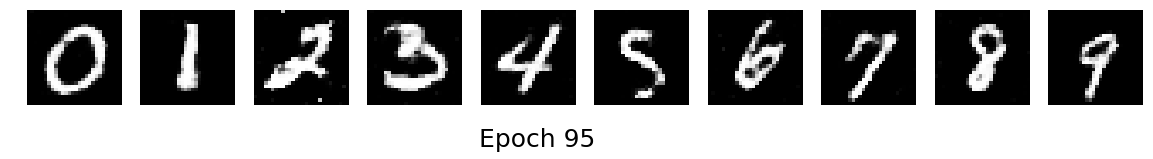

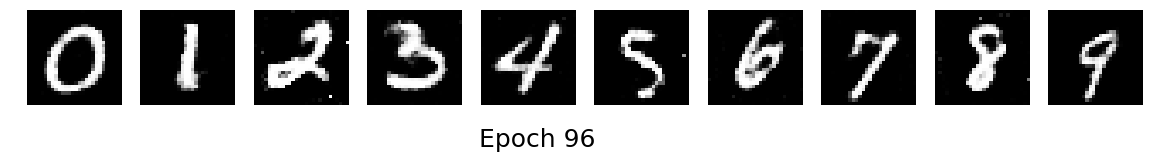

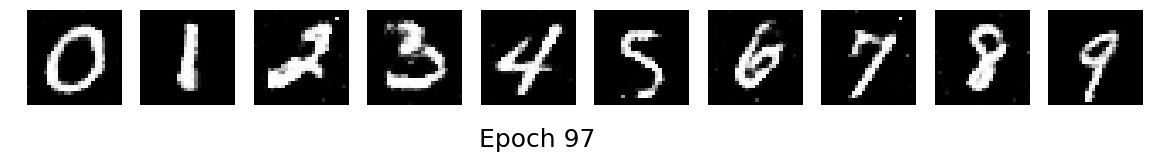

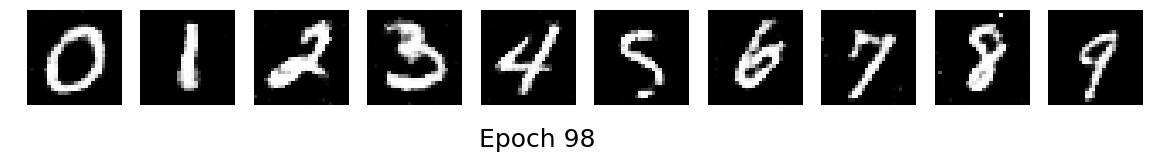

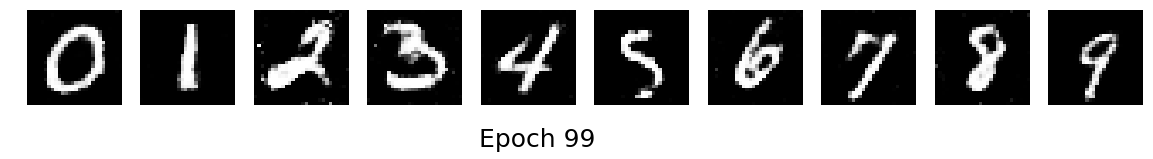

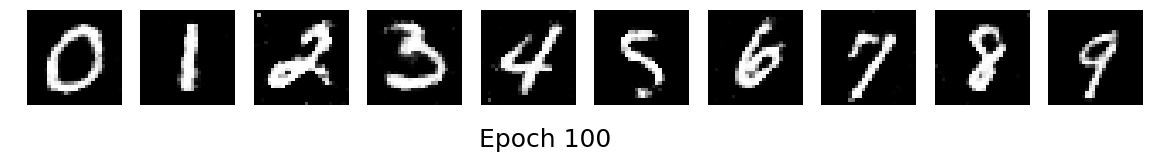

In [11]:
show_save_samples(sample_images_generated, save=True, gif_frame_duration=0.3)